In [0]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt


###check the content of folder

##check each file one by one

unpickle pickle file, "genre_to_mxm_track_dict.pkl" is a dictionary with values as genre type and each value has key which contain song lyrics token. 

In [0]:
import pickle
with open('genre_to_mxm_track_dict.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
type(data)

collections.defaultdict

check the genre as keys of dictionary

In [8]:
data.keys()

dict_keys(['rock', 'hip-hop', 'pop', 'metal', 'electronic', 'country', 'alternative', 'r&b'])

corresponding to each key, there is a list which contain tag id of song. this dictionary does not contain whole lyrics of song but just its tag id. 
Here I have printed each genre with number of songs tagid corresponding to each genre. try prining data["rock"] to check the list of tagid for rock genre
Musixmatch dataset recognize songs with these tagids

In [9]:
for key in data.keys():
  print( key , len(data[key]))

rock 115724
hip-hop 202581
pop 51199
metal 32316
electronic 34755
country 15603
alternative 8551
r&b 1356


Unpickle "mxm_track_to_genre_dict.pkl" file. 
This is dictionary with keys as song tagids and each key contain only one value i.e. its genre

In [0]:
import pickle
with open('mxm_track_to_genre_dict.pkl', 'rb') as f:
    data = pickle.load(f)

it contains 396863 song tagids.

In [11]:
len(data)

396863

check how this dictionary looks like

since million song database database does not contain direct genre as label but tags like " a beautiful rock song". below printed 500 tags to the tracks/songs

tids.csv file contain all the track ids ( track ids are ids given to each song. it is like pointer to a dataset) 
Note : these track ids are of million song database not of Musixmatch dataset.

In [0]:
import csv
with open('tids.csv','rt')as f:
  data = csv.reader(f)
  for i, row in enumerate(data):
    if i==500:
       break
    print(row)

In [13]:
!unzip 'mxm_dataset_train.txt.zip'

Archive:  mxm_dataset_train.txt.zip
replace mxm_dataset_train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


this is text file containing top 5000 words, Million song dataset track id, Musixmatch track id and (token:count) for each word in lyrics. Download it and paste in your working directory. Then run the given code in cell below, that will create a pickle dictionary named "mxm_track_to_vector_dict.pkl"

http://millionsongdataset.com/sites/default/files/AdditionalFiles/mxm_dataset_train.txt.zip 

In [0]:
import csv
import collections
import operator
import pickle
import os

def convert_to_ndarray(d):
    arr = [0] * 5000
    for key, val in d.items():
        key = int(key) - 1
        arr[key] = val
    return arr

track_to_vector_dict = {}

with open('mxm_dataset_train.txt', 'r') as f:
	out = f.readlines()
	for line in out: 
		line = line.strip('\n')
		if line[0] != '#': 
			if line[0] == '%': 
				VOCAB = line.split(',')
			else: 
				d = {}
				splitted = line.split(',')
				_ = splitted[0]
				tid = splitted[1]
				for unsplit_dict in splitted[2:]:
					pair = unsplit_dict.split(':')
					index = int(pair[0])
					count = int(pair[1])
					d[index] = count
				track_to_vector_dict[tid] = convert_to_ndarray(d)

with open('mxm_track_to_vector_dict.pkl', 'wb') as f: 
  pickle.dump(track_to_vector_dict, f)

In [0]:
VOCAB[0] = 'i'
VOCAB

### "'mxm_track_to_vector_dict.pkl'" is a dictionary whose keys are track id in Musixmatch dataset and value corresponding to each key is vector of 5000 tokens as index and with scores (count of that word in song) at each index

In [0]:
import csv
import collections
import operator
import pickle
import os
import numpy as np

explore data if you want to. try printing keys and value for any key for intuition of data

In [0]:
with open('mxm_track_to_vector_dict.pkl', 'rb') as f:
    data = pickle.load(f)

In [18]:
list(data.keys())[:10]

['4623710',
 '6477168',
 '2516445',
 '3759847',
 '3783760',
 '6640025',
 '5493388',
 '5133845',
 '1619153',
 '8525084']

In [19]:
len((list(data.values())[:1])[0])

5000

##Here we have completed our data preprocessing. 
we have three pickle file. thats our dataset.

TASK : 
READ FEATURE SELECTION PART. 
SEARCH HOW TO CLASSIFY SEQUENCE DATA.
Read train_test.py 

In [0]:
with open('mxm_track_to_genre_dict.pkl', 'rb') as f: 
	track_to_genre_dict = pickle.load(f)

with open('genre_to_mxm_track_dict.pkl', 'rb') as f: 
  genre_to_tracks_dict = pickle.load(f)

In [0]:
genre_mean_dict = {}

for genre in genre_to_tracks_dict:
	tracks = genre_to_tracks_dict[genre]
	vecs = []
	for track in tracks: 
		if track in data.keys():
			vecs.append(data[track])
	genre_mean_dict[genre] = np.mean(vecs, axis=0)

In [22]:
len(track_to_genre_dict)

396863

In [23]:
len(data)

210519

In [0]:
overlap = []
for key in track_to_genre_dict.keys():
	if key in data.keys():
		overlap.append(key)

genre_list = []
track_list = []
for o in overlap:
  genre_list.append(track_to_genre_dict[o])

In [0]:
track_to_genre_id_dict = {}
for i,genre in enumerate(genre_to_tracks_dict.keys()):
  track_to_genre_id_dict[genre] = i

In [26]:
track_to_genre_id_dict

{'alternative': 6,
 'country': 5,
 'electronic': 4,
 'hip-hop': 1,
 'metal': 3,
 'pop': 2,
 'r&b': 7,
 'rock': 0}

Creating data to pass into classifier and clustering
###x 
contain all the vector that overlap in Track to genre dictionary and mxm_track_to_vector_dict.pkl. 
Since all song's genre couldn't be extracted from tags.
###Y
list that contain all the genre corresponding to each song lyrics
###label 
contain id given to genre

In [0]:
x = []
y_ = []
label = []
trk=[]
count_dict = collections.defaultdict(int)

for o in overlap:
  if track_to_genre_dict[o] != 'r&b':
    if count_dict[track_to_genre_dict[o]] < 4216:
      count_dict[track_to_genre_dict[o]] += 1
      x.append(data[o])
      trk.append(o)
      y_.append(track_to_genre_dict[o])
      label.append(track_to_genre_id_dict[track_to_genre_dict[o]])

Here TfidfTransformer is imported from sklearn library.
###Why converted lyrics into vectors (word embedding)
In very simplistic terms, Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text. many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. 
###Types of word embedding
Frequency based word embedding
Probabilistic based word embedding
### count vector (current word embedding)
Consider a Corpus C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens will form our dictionary and the size of the Count Vector matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).
###why TfidfTransformer
This is another method which is based on the frequency method but it is different to the count vectorization in the sense that it takes into account not just the occurrence of a word in a single document but in the entire corpus. So, what is the rationale behind this? Let us try to understand.

Common words like ‘is’, ‘the’, ‘a’ etc. tend to appear quite frequently in comparison to the words which are important to a document. For example, a document A on Lionel Messi is going to contain more occurences of the word “Messi” in comparison to other documents. But common words like “the” etc. are also going to be present in higher frequency in almost every document.

Ideally, what we would want is to down weight the common words occurring in almost all documents and give more importance to words that appear in a subset of documents.


###Check out this amazing tutorial to better understand word embedding
https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = TfidfTransformer()
vec = vectorizer.fit_transform(x)
vec = vec.todense()

In [29]:
type(vec)

numpy.matrix

In [0]:
import torch
x = torch.FloatTensor(x)
label = torch.LongTensor(label)
vec = torch.FloatTensor(vec)

In [31]:
print(x.shape, vec.shape)

torch.Size([29512, 5000]) torch.Size([29512, 5000])


In [0]:
x=vec

In [33]:
type(x)

torch.Tensor

###Split into test and train dataset

In [0]:
import random

c = list(zip(x, label))
random.shuffle(c)
x, label = zip(*c)
x = list(x)
label = list(label)

x_train = x[:-3000]
y_train = label[:-3000]
x_test = x[-3000:]
y_test = label[-3000:]

In [0]:
train_dataset= c[:-3000]
test_dataset= c[-3000:]

In [37]:
len(test_dataset)

3000

###Creating dataloader 

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [39]:
print(len(train_dataset))
print(len(next(iter(train_loader))))

26512
2


###Setting hyperparameters for Classifier

In [0]:
input_dim = 5000
hidden_dim = 1024
out_dim = 8
n_embed = 128

###Creating model architecture for genre classification based on lyrics

We will be using neural network here, there are various other techniques but I beleive Neural network outperform them all

In [0]:
class classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, out_dim)
    self.logsoftmax = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.dropout(self.layer1(x), p=0.5, training = True)
    x = self.layer2(x)
    x = self.logsoftmax(x)
    return x

In [0]:
model = classifier()

### choosing loss function and optimizer for training

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

###training
i have just trained for 5 epochs , for better accuracy train for more epochs using scheduler for learning rate decay and avoid overfitting

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
epochs = 5
steps = 0
print_every = 5
train_losses, val_losses = [], []

for epoch in range(epochs):
  
  train_loss =0
  for x, y in train_loader:
    steps+=1
    
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    log_ps = model.forward(x)
    loss = criterion(log_ps, y) 
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
    
    if (steps%print_every == 0):
      test_loss =0
      accuracy=0
      model.eval()
      with torch.no_grad():
        for x, y in test_loader:
          x, y = x.to(device), y.to(device)
          log_ps = model.forward(x)
          loss = criterion(log_ps, y)
          test_loss += loss.item()
          
          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == y.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
      print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
      train_loss = 0
      model.train()

Epoch 1/5.. Train loss: 2.080.. Test loss: 2.078.. Test accuracy: 0.183
Epoch 1/5.. Train loss: 2.076.. Test loss: 2.073.. Test accuracy: 0.197
Epoch 1/5.. Train loss: 2.071.. Test loss: 2.069.. Test accuracy: 0.215
Epoch 1/5.. Train loss: 2.066.. Test loss: 2.064.. Test accuracy: 0.211
Epoch 1/5.. Train loss: 2.062.. Test loss: 2.060.. Test accuracy: 0.215
Epoch 1/5.. Train loss: 2.057.. Test loss: 2.055.. Test accuracy: 0.234
Epoch 1/5.. Train loss: 2.053.. Test loss: 2.051.. Test accuracy: 0.247
Epoch 1/5.. Train loss: 2.050.. Test loss: 2.046.. Test accuracy: 0.265
Epoch 1/5.. Train loss: 2.045.. Test loss: 2.042.. Test accuracy: 0.271
Epoch 1/5.. Train loss: 2.041.. Test loss: 2.038.. Test accuracy: 0.288
Epoch 1/5.. Train loss: 2.035.. Test loss: 2.033.. Test accuracy: 0.281
Epoch 1/5.. Train loss: 2.034.. Test loss: 2.029.. Test accuracy: 0.288
Epoch 1/5.. Train loss: 2.028.. Test loss: 2.024.. Test accuracy: 0.289
Epoch 1/5.. Train loss: 2.024.. Test loss: 2.020.. Test accuracy

Now the idea is to cluster vectors of lyrics into clusters. I have choosen number of clusters 20. you can increase of decrease the number.
###Why choose clustering over classification into 10 genre
if we are classifying we will be forcing them to classify into 10 class but any song is not pure rock or blues, so clustering will allow them to cluster in more than 10 classes|

In [0]:
from sklearn.cluster import KMeans

In [46]:
vec_num = vec.numpy()
print(vec_num.shape)
kmeans = KMeans(n_clusters=20, random_state=0).fit(vec)

(29512, 5000)


In [47]:
len(kmeans.labels_)

29512



```
means = kmeans.cluster_centers_
```

means will contain all the centroid of clusters formed. it will be 5000 dimension vector same as song lyrics vector length

In [48]:
means = kmeans.cluster_centers_
means[0]

array([ 8.20609680e-03,  8.15059817e-03,  7.12476205e-03, ...,
       -1.32814766e-18, -1.19262239e-18, -2.71050543e-19])

In [49]:
print(list(track_to_genre_dict.keys())[:10]) 
print(list(track_to_genre_dict.values())[:10]) 

['8898149', '7362052', '7833814', '2320200', '4280619', '674743', '8851472', '9855482', '610698', '721926']
['hip-hop', 'hip-hop', 'hip-hop', 'hip-hop', 'pop', 'hip-hop', 'metal', 'rock', 'hip-hop', 'pop']


###loading the user query data

In [0]:
from scipy import sparse
query= sparse.load_npz('querydata.npz')
query=sparse.csr_matrix.todense(query)

###splitting into train and test dataset

In [0]:
label = torch.LongTensor(kmeans.labels_)
x = torch.FloatTensor(query)

c = list(zip(x, label))
random.shuffle(c)
x, label = zip(*c)
x = list(x)
label = list(label)

x_train = x[:-3000]
y_train = label[:-3000]
x_test = x[-3000:]
y_test = label[-3000:]

train_dataset= c[:-3000]
test_dataset= c[-3000:]

###creating dataloaders

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, drop_last=True ,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=True)

### Recommender model architecture
This model will learn how to map user query to most suitable cluster of song lyrics. Here input is user query converted into 5000 length vector and target is mean of cluster formed by Kmeans algorithm above

In [0]:
class recommender(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(5000, 512)
    self.layer2 = nn.Linear(512, 5000)
  def forward(self, x):
    x = F.dropout(self.layer1(x), p=0.5, training = True)
    x = self.layer2(x)
    return x

model = recommender()

In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

###Cosine function
used to find similarity between prediction given by model and each cluster mean. closest cluster will be assigned to that query

In [0]:
from scipy.spatial.distance import cosine

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
epochs = 1
steps = 0
print_every = 5
train_losses, val_losses = [], []

for epoch in range(epochs):
  
  train_loss =0
  for x, y in train_loader:
    steps+=1
    #print((y))
    y = torch.FloatTensor(means[(y)])
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model.forward(x)
    loss = criterion(out, y) 
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
    
    if (steps%print_every == 0):
      test_loss =0
      accuracy=0
      equals=0
      model.eval()
      with torch.no_grad():
        for x, y_label in test_loader:
          equals=0
          y = torch.FloatTensor(means[(y_label)])
          x, y = x.to(device), y.to(device)
          out = model.forward(x)
          loss = criterion(out, y)
          test_loss += loss.item()
          out = out.cpu()
          
          for i, outvec in enumerate(out):
            clr_list = []
            mini = 100000.0
            clr = 0
            for cluster in range(20):
              sim = cosine(outvec, means[cluster])
              if sim < mini:
                mini = sim
                clr = cluster
      
            if clr == y_label[i]:
              equals += 1
          #print(equals)
          accuracy += equals/128
          
      print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.8f}.. "
                  f"Test loss: {test_loss/len(test_loader):.8f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
      train_loss = 0
      model.train()

Epoch 1/1.. Train loss: 0.00071968.. Test loss: 0.00068545.. Test accuracy: 0.012
Epoch 1/1.. Train loss: 0.00066147.. Test loss: 0.00062646.. Test accuracy: 0.012
Epoch 1/1.. Train loss: 0.00060336.. Test loss: 0.00057006.. Test accuracy: 0.017
Epoch 1/1.. Train loss: 0.00054788.. Test loss: 0.00051564.. Test accuracy: 0.037
Epoch 1/1.. Train loss: 0.00049423.. Test loss: 0.00046222.. Test accuracy: 0.050
Epoch 1/1.. Train loss: 0.00044138.. Test loss: 0.00040835.. Test accuracy: 0.077
Epoch 1/1.. Train loss: 0.00038744.. Test loss: 0.00035550.. Test accuracy: 0.097
Epoch 1/1.. Train loss: 0.00033470.. Test loss: 0.00030404.. Test accuracy: 0.108
Epoch 1/1.. Train loss: 0.00028566.. Test loss: 0.00025518.. Test accuracy: 0.115
Epoch 1/1.. Train loss: 0.00023689.. Test loss: 0.00021213.. Test accuracy: 0.120
Epoch 1/1.. Train loss: 0.00019696.. Test loss: 0.00017641.. Test accuracy: 0.129
Epoch 1/1.. Train loss: 0.00016478.. Test loss: 0.00014875.. Test accuracy: 0.133
Epoch 1/1.. Trai

##Training part completed.
Now checking results from model. 
###query
query provided by user
###vector
first dictionary was made using VOCAL. keys is token id, value is occurence of token in query. Then converted to vector of 5000 dim

In [57]:
from collections import defaultdict
query = "i want to hear some fast hard band loud music which feel like storm"
query = query.split(" ")
print(query)
token = defaultdict(int)
for word in query:
  token[VOCAB.index(word)] += 1
print(token)
vector=convert_to_ndarray(token)
vector = torch.Tensor(vector)
vector = vector.view(1,-1); vector

['i', 'want', 'to', 'hear', 'some', 'fast', 'hard', 'band', 'loud', 'music', 'which', 'feel', 'like', 'storm']
defaultdict(<class 'int'>, {0: 1, 61: 1, 3: 1, 164: 1, 135: 1, 552: 1, 222: 1, 968: 1, 869: 1, 379: 1, 673: 1, 60: 1, 35: 1, 775: 1})


tensor([[0., 0., 1.,  ..., 0., 0., 1.]])

###conveting into Tfidfvector

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = TfidfTransformer()
vector = vectorizer.fit_transform(vector)
vector = vector.todense()
vector = torch.FloatTensor(vector)
vector = vector.to(device); vector

tensor([[0.0000, 0.0000, 0.2673,  ..., 0.0000, 0.0000, 0.2673]],
       device='cuda:0')

Prediction by model

In [0]:
outvec = model.forward(vector)

choosing the closest cluster

In [0]:
mini = 10000
clr = 0
for cluster in range(20):
    sim = cosine(outvec.detach().cpu().numpy(), means[cluster])
    if sim < mini:
        mini = sim
        clr = cluster

In [85]:
clr

5

selecting all the songs in that cluster

In [62]:
labels = np.array(kmeans.labels_)
index= list(np.where(labels == clr)[0]); len(index)

3363

In [63]:
data_vectors = torch.Tensor(vec_num); data_vectors

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3100, 0.2402,  ..., 0.0000, 0.0000, 0.0000],
        [0.3268, 0.1217, 0.2546,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1521, 0.1062, 0.1382,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0872, 0.3650,  ..., 0.0000, 0.0000, 0.0000],
        [0.1151, 0.0214, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

calculating cosine distance from each song of cluster

In [0]:
difference = []
for vec in data_vectors[index]:
  difference.append(cosine(vector.cpu(), vec))

extracting top 10 songs

In [65]:
K = sorted(difference)[10]; K

0.8030866086483002

In [66]:
mask = difference < K
similar_index = list(np.where(mask==True)[0]); similar_index

[177, 350, 632, 1499, 1886, 2409, 2467, 2489, 2823, 2976]

checking genre and tag ids of those songs

In [67]:
gnr=[]
tracks=[]
for index in similar_index:
  gnr.append(y_[index])
  tracks.append(trk[index])
print(gnr, tracks)

['metal', 'pop', 'country', 'rock', 'hip-hop', 'rock', 'rock', 'country', 'hip-hop', 'hip-hop'] ['6870821', '9274434', '1012073', '4488030', '1738581', '770937', '3146680', '7648691', '4390555', '630798']


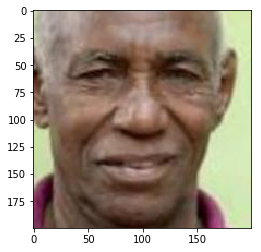

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('65_0_1_20170117194017535.jpg.chip.jpg')
imgplot = plt.imshow(img)
plt.show()

##Relation between Gender and Music Genres


![alt text](http://musicstats.org/wp-content/uploads/2016/10/capture1-1.png) 

female = [47, 38, 8, 20, 20, 25]           male = [8, 20, 14, 30, 30, 27]

Gender Classification Model Predicted gender = Male

##Relation between age and music genre

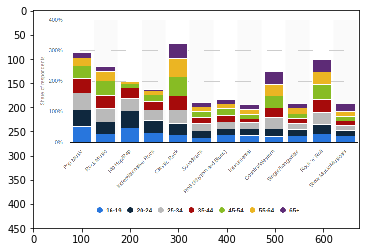

In [69]:
img=mpimg.imread('Screenshot_2019-08-20 Favorite music genres among consumers by age group in the U S 2018 Statista.png')
imgplot = plt.imshow(img)
plt.show()

Age Classification model Predicted age = 36

In [0]:
age = 36

In [71]:
a=np.array([[23,28,48,52,20,22,19,31],[22,39,54,54,19,23,26,40],[22,44,42,56,17,20,37,35],[22,42,33,46,14,13,31,28],[21,48,15,52,15,13,38,21],[15,31,5,25,16,17,38,13],[16,17,1,19,24,16,40,5]])
print(np.sum(a,0))
a= a/np.sum(a,0)

[141 249 198 304 125 124 229 173]


In [72]:
a

array([[0.16312057, 0.1124498 , 0.24242424, 0.17105263, 0.16      ,
        0.17741935, 0.08296943, 0.17919075],
       [0.15602837, 0.15662651, 0.27272727, 0.17763158, 0.152     ,
        0.18548387, 0.11353712, 0.23121387],
       [0.15602837, 0.17670683, 0.21212121, 0.18421053, 0.136     ,
        0.16129032, 0.16157205, 0.20231214],
       [0.15602837, 0.1686747 , 0.16666667, 0.15131579, 0.112     ,
        0.10483871, 0.13537118, 0.16184971],
       [0.14893617, 0.19277108, 0.07575758, 0.17105263, 0.12      ,
        0.10483871, 0.16593886, 0.12138728],
       [0.10638298, 0.12449799, 0.02525253, 0.08223684, 0.128     ,
        0.13709677, 0.16593886, 0.07514451],
       [0.11347518, 0.06827309, 0.00505051, 0.0625    , 0.192     ,
        0.12903226, 0.17467249, 0.02890173]])

According to above results, top three genre are selected and arranged preference wise.

In [0]:
age16_19 = ['hip-hop', 'alternative', 'electronic']
age20_24 = ['hip-hop', 'alternative', 'electronic']
age25_34 = ['hip-hop', 'alternative', 'pop']
age35_44 = ['rock', 'hip-hop', 'alternative']
age45_54 = ['rock', 'pop', 'country']
age55_64 = ['country', 'electronic', 'metal']
age65_80 = ['metal', 'country', 'electronic']

In [0]:
if age>16 and age<19:
  g = age16_19
elif age>20 and age<24:
  g = age20_24
elif age>25 and age<34:
  g = age25_34
elif age>35 and age<44:
  g = age35_44
elif age>45 and age<54:
  g = age45_54
elif age>55 and age<65:
  g = age55_65
else:
  g = age65_80

In [75]:
print(age, g)

36 ['rock', 'hip-hop', 'alternative']


In [76]:
music_tag=[]
for gen_cv in g:
  count = 0
  for gen_nlp in gnr:
    if gen_cv == gen_nlp:
      music_tag.append(tracks[count])
    count += 1
print(music_tag)

['4488030', '770937', '3146680', '1738581', '4390555', '630798']


Above tracks are top songs ids according to nlp and cv combined. we can take any top 5 out of them.

In [77]:
if len(music_tag) >=5:
  reccomended_ids = music_tag[:5]
else:
  reccomended_ids = music_tag
reccomended_ids

['4488030', '770937', '3146680', '1738581', '4390555']